modelName: ResNet50
patience:  100
lr:  0.001
bs:  10
pretrained:  True
fatal: destination path 'keras-video-generators' already exists and is not an empty directory.
Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
  Using cached tensorflow-2.8.0-cp310-cp310-manylinux2010_x86_64.whl (497.6 MB)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 12, 18432)        23587712  
 tributed)                                                       
                                                                 
 lstm_6 (LSTM)               (None, 64)                4735232   
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 150)               9750      
                                                                 
 dropout_13 (Dropout)        (None, 150)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 302       
                                                     

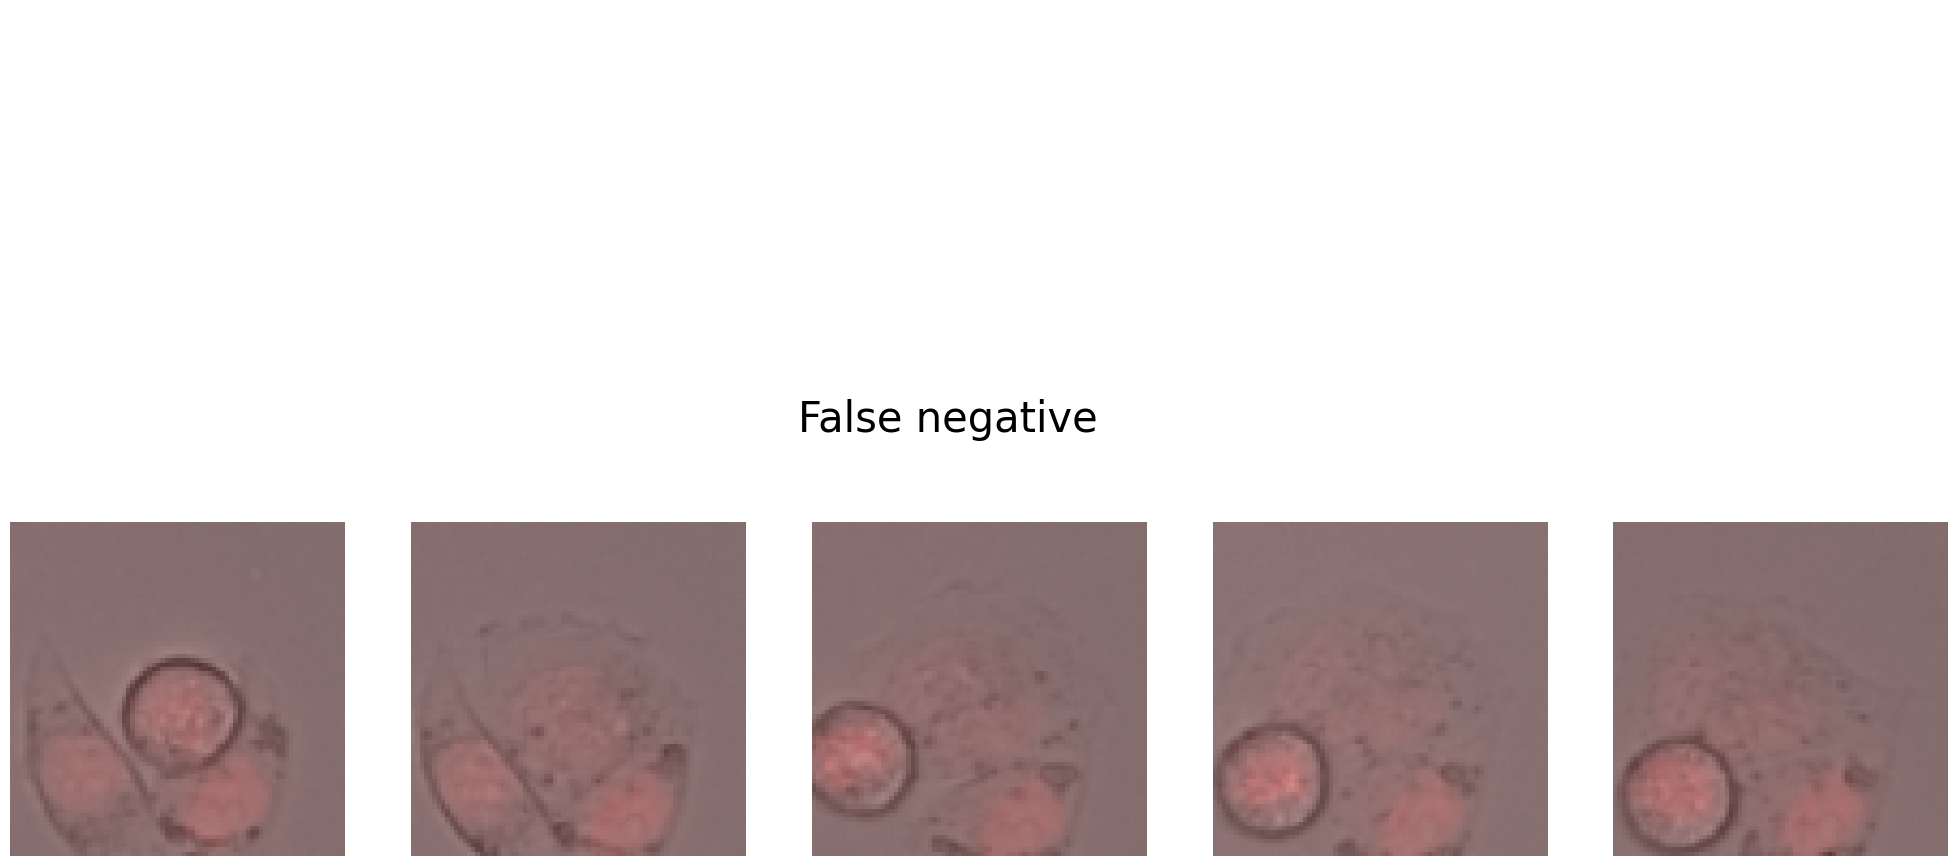

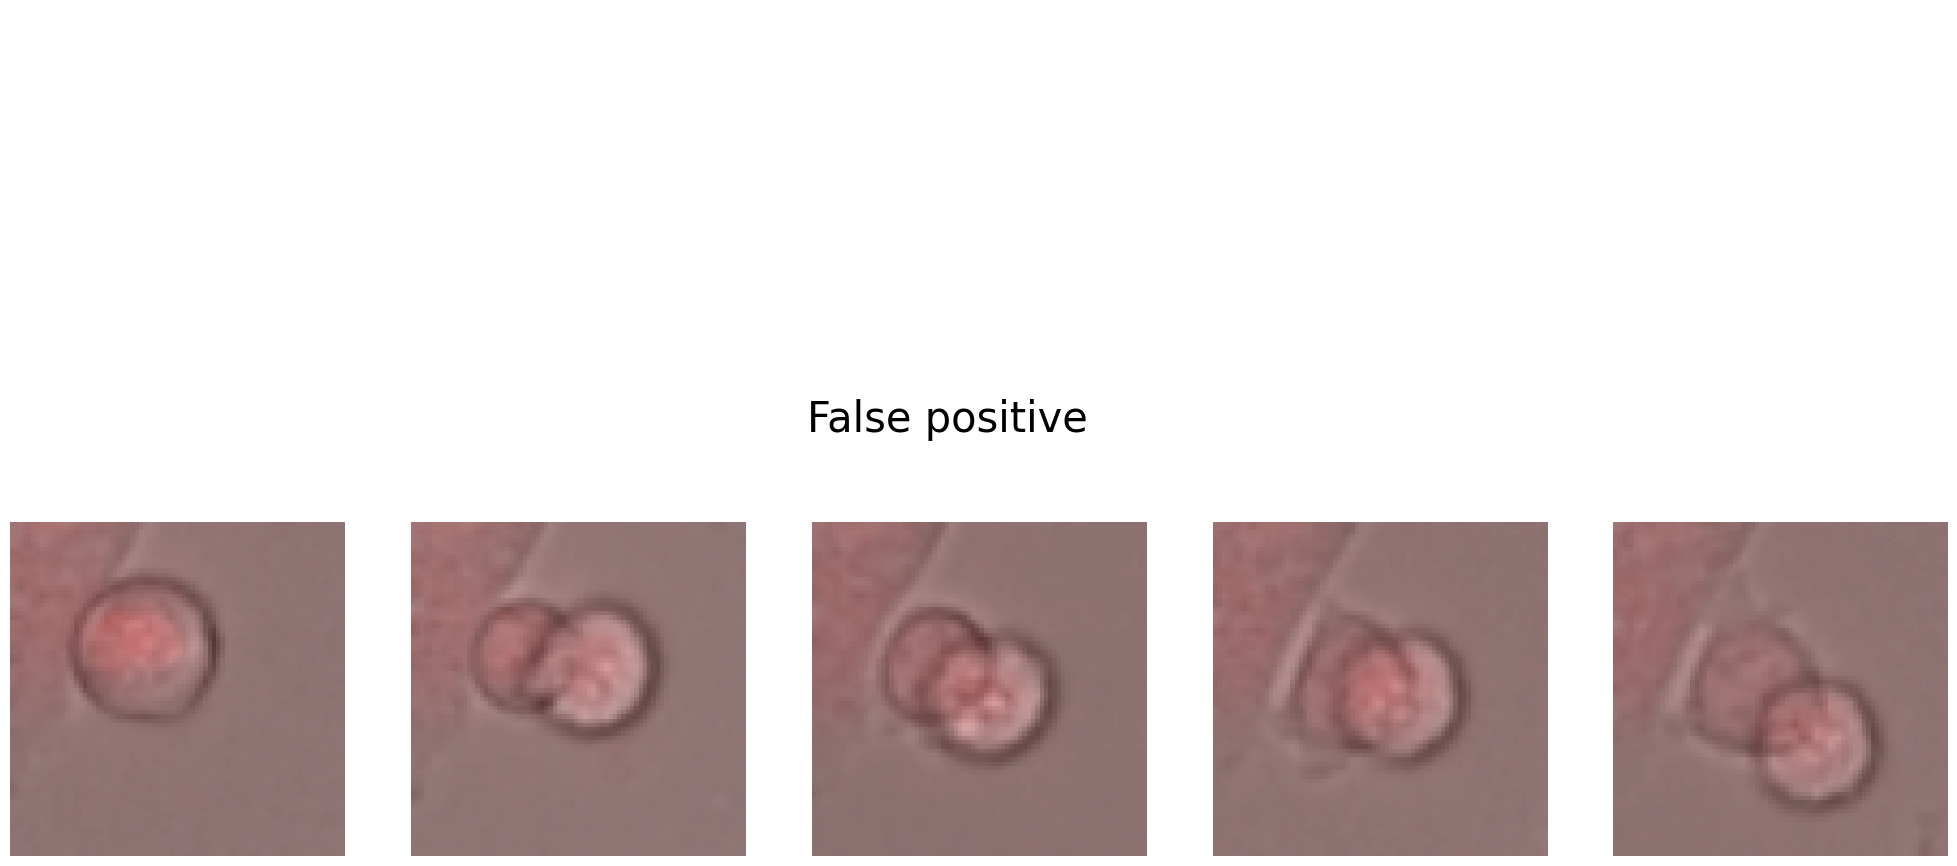

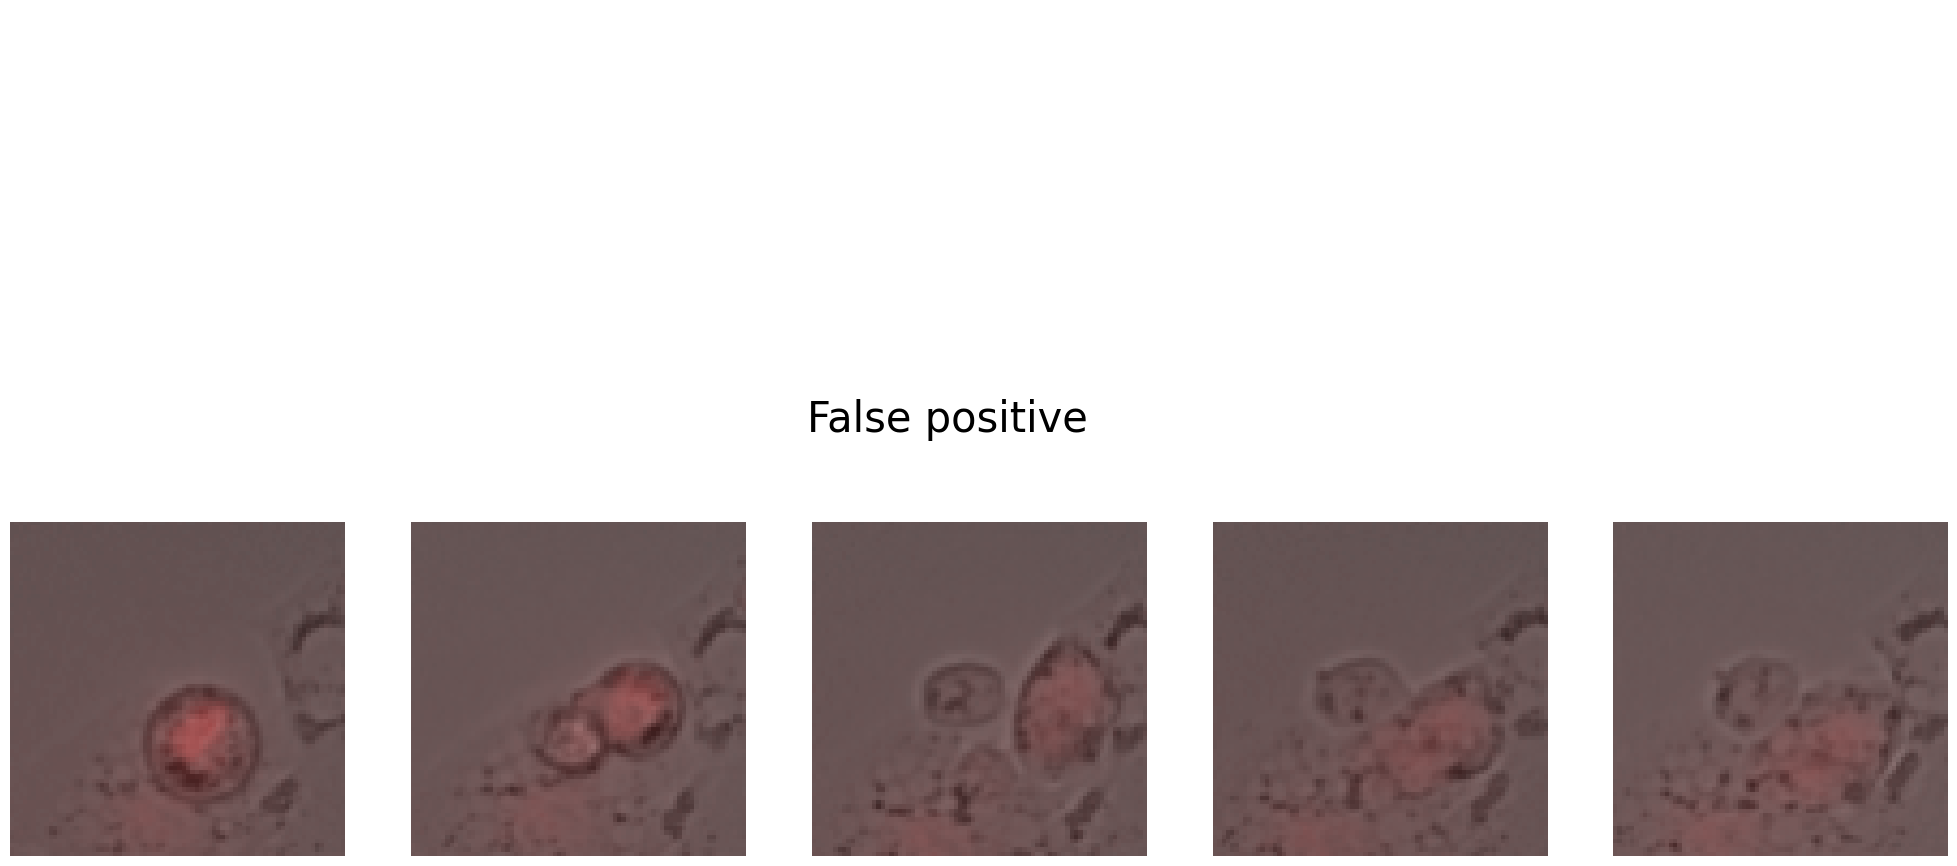

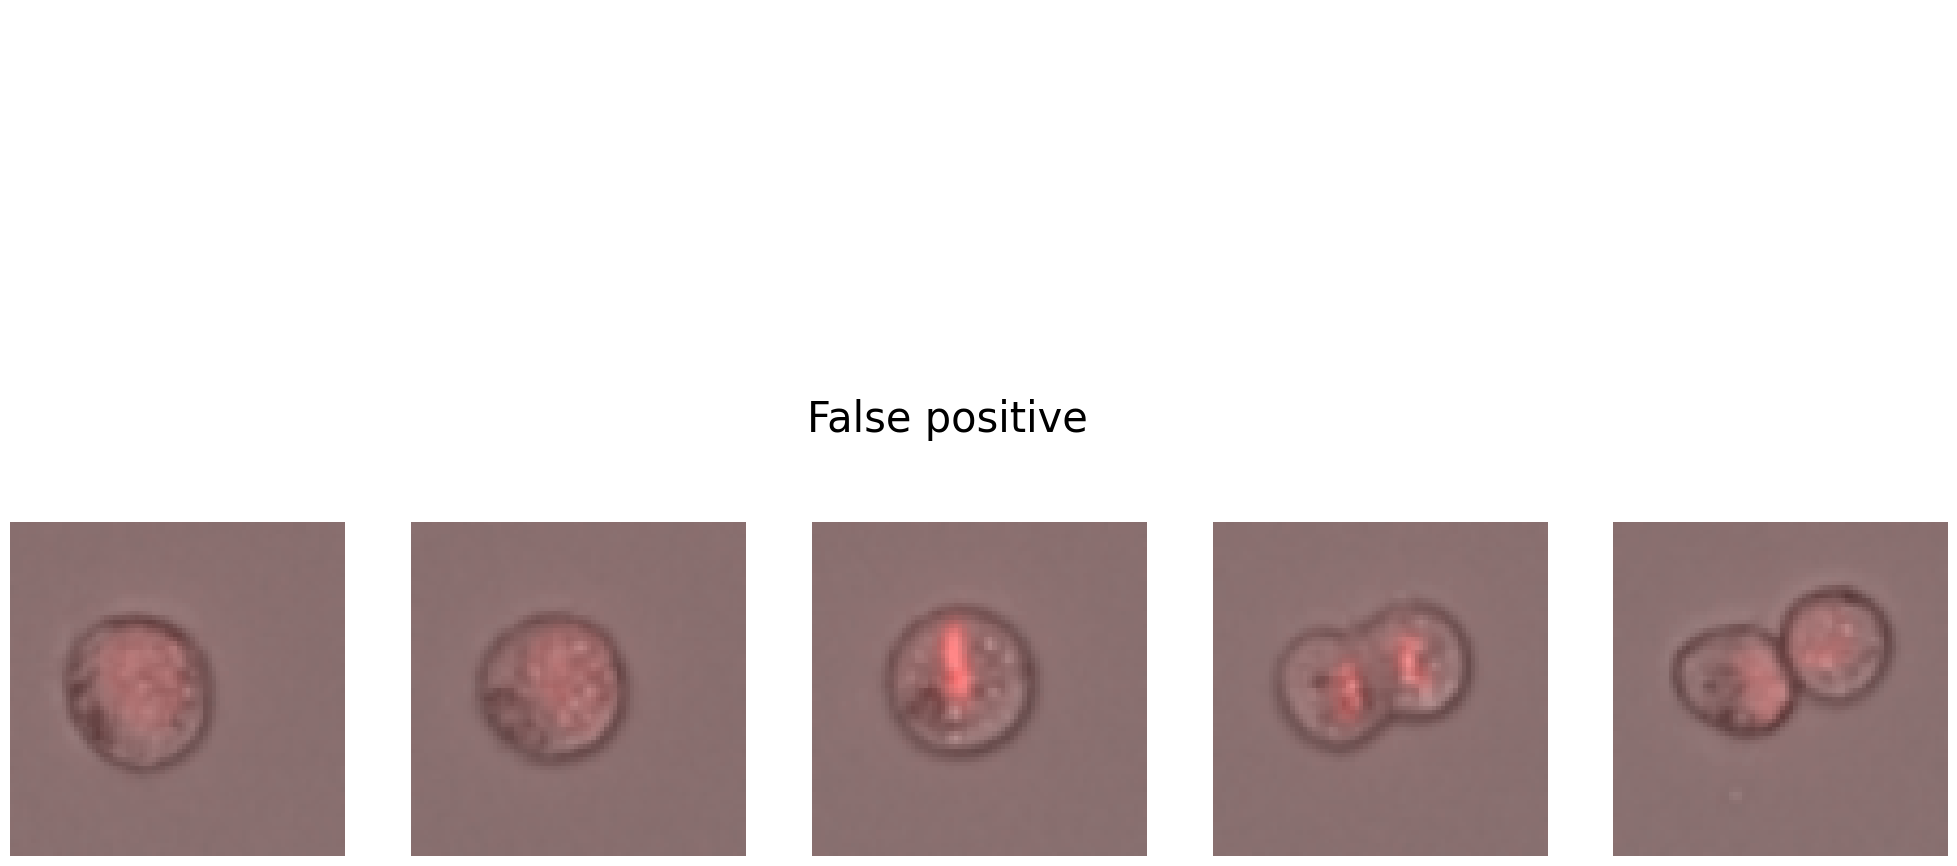

In [8]:
#This code shows false positive and false negative examples (errors) of a specific training from a specific architecture, applied on the test data.

#INPUT PARAMETERS

#No need to change the main path
#mainFolderfullPath = '/content/drive/MyDrive/Pablo Delgado/Nantes-Madrid/MITOSIS CLASSIFICATION/Publications/Publications code/Epochs-500, patience-100'
mainFolderfullPath = '/content/drive/MyDrive/Pablo Delgado/Nantes-Madrid/Publications/Mitosis classifier/Publications code/Epochs-500, patience-100'

#Test images path
testImPath = '/content/drive/MyDrive/Pablo Delgado/Nantes-Madrid/Publications/Mitosis classifier/Publications code/Rebuttal/newTestData'

#Folder with the model you want to use (include "/best_weights-step2" if pretrained = True)
modelFolder = 'ResNet50-best_weights_patience100-lr0.001-bs10-pretrained/best_weights-step2'

#resultsFolder = '/content/drive/MyDrive/Pablo Delgado/Nantes-Madrid/Publications/Mitosis classifier/Publications code/Rebuttal/Results on new data'
#To try to provide a shorter path:
resultsFolder = '/content/drive/MyDrive/Pablo Delgado/Nantes-Madrid/Results on new data'

#iter = 0

#Save or not save the test results
save = True

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Constants

numIters = 0

step = 2

#Extract model name and hyperparameters from the model's path
nameInParts = modelFolder.split('-')
modelName = nameInParts[0]
print('modelName:', modelName)
patience = int(nameInParts[1].split('patience')[1])
print('patience: ',patience)
lr = float(modelFolder.split('-lr')[1].split('-bs')[0])
print('lr: ',lr)
bs = int(modelFolder.split('-bs')[1].split('-')[0])
print('bs: ',bs)
pretrained = ('from_scratch' != nameInParts[-1])
print('pretrained: ',pretrained)

#iterName = str(iter)

#Install and import libraries


!pip install elasticdeform
#!pip install keras --upgrade
!git clone --branch patch-1  https://github.com/pdelgado248/keras-video-generators.git

#To solve an error loading "from tensorflow.compat.v2.experimental import dtensor as dtensor_api"
!pip uninstall -y tensorflow
!pip install  tensorflow==2.8

#!pip uninstall -y keras
#!pip install keras==2.6.*
!pip install keras-video-generators
!pip install -U keras-tuner

import numpy as np
import sys
sys.path.insert(0, '/content/keras-video-generators/src')

import os
from glob import glob


import tensorflow as tf

#import tensorflow.keras as keras
import keras

#keras = tf.python.keras


#initializers = tf.python.keras.initializers
#layers = tf.python.keras.layers
#models = tf.python.keras.models
#optimizers = tf.python.keras.optimizers
#metrics = tf.python.keras.metrics
#regularizers = tf.python.keras.regularizers

#K = tf.python.keras.backend

from tensorflow.python.keras import initializers, layers, models, optimizers, metrics, regularizers
from tensorflow.python.keras import backend as K

#from keras import initializers, layers, models, optimizers, metrics, regularizers
#from keras import backend as K

from keras_video import VideoFrameGenerator
from kerastuner.tuners import RandomSearch, Hyperband
import IPython

import matplotlib.pyplot as plt






# Define global params

CLASSES = 2                 # Number of classes
SIZE = (78, 78)             # Image input size
CHANNELS = 3                # Number of channels: 3 RGB, 1 Grayscale
NBFRAME = 12                # Number of video frames
SHAPE = SIZE + (CHANNELS,)  # Shape = size + channel (78, 78, 3)
INSHAPE = (NBFRAME,) + SHAPE  # Video-shape = frame + shape (12, 78, 78, 3)





#MODEL DEFINITION

#*************************************************************************************************************************************
#-------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------
#Models


#VGG16
if modelName == 'VGG16':

  from keras.layers import Flatten, TimeDistributed, GRU, Dense, Dropout, LSTM

  def build_convnet(step):

      model = tf.keras.applications.VGG16(
      include_top=False,
      input_shape=SHAPE
      )

      output = Flatten()

      return keras.models.Sequential([model, output])


  def action_model(shape=(12, 78, 78, 3), nbout=2,step=step):
      # Here we call our conv network
      convnet = build_convnet(step)

      # Final model
      model = tf.python.keras.Sequential()
      # Call convnet into the TimeDistributed layer with video shape
      model.add(TimeDistributed(convnet, input_shape=shape))
      # LSTM for temporal features extraction
      model.add(LSTM(64))
      # Classification part
      model.add(Dropout(.4))
      model.add(Dense(150, activation='relu', kernel_regularizer=tf.python.keras.regularizers.l2(0.01)))
      model.add(Dropout(.2))
      model.add(Dense(nbout, activation='softmax'))

      return model

#-------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------

elif modelName == 'Xception':

  from keras.layers import Flatten, GlobalMaxPooling2D,TimeDistributed, GRU, Dense, Dropout, LSTM
  def build_convnet(step):

      model = keras.applications.Xception(
          include_top=False,
          input_shape=SHAPE
      )

      output = Flatten()

      return tf.keras.Sequential([model, output])

  def action_model(shape=(12, 78, 78, 3), nbout=2,step=step):
      # Here we call our conv network
      convnet = build_convnet(step)

      # Final model
      model = tf.keras.Sequential()
      # Call convnet into the TimeDistributed layer with video shape
      model.add(TimeDistributed(convnet, input_shape=shape))
      # LSTM for temporal features extraction
      model.add(LSTM(64))
      # Classification part
      model.add(Dropout(.4))
      model.add(Dense(150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
      model.add(Dropout(.2))
      model.add(Dense(nbout, activation='softmax'))

      return model

#-------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------

elif modelName == 'ResNet50':

  from keras.layers import Flatten, GlobalMaxPooling2D,TimeDistributed, GRU, Dense, Dropout, LSTM
  from keras.applications.resnet import ResNet50

  def build_convnet(step):
      model = ResNet50(
          include_top=False,
          input_shape=SHAPE
      )

      output = Flatten()

      return keras.models.Sequential([model, output])


  def action_model(shape=(12, 78, 78, 3), nbout=2,step=step):
      # Here we call our conv network
      convnet = build_convnet(step)

      # Final model
      model = tf.keras.Sequential()
      # Call convnet into the TimeDistributed layer with video shape
      model.add(TimeDistributed(convnet, input_shape = shape))
      # LSTM for temporal features extraction
      model.add(LSTM(64))
      # Classification part
      model.add(Dropout(.4))
      model.add(Dense(150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
      model.add(Dropout(.2))
      model.add(Dense(nbout, activation='softmax'))

      return model

#-------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------

elif modelName == 'Gao':

  from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Flatten,TimeDistributed, GRU, Dense, Dropout, LSTM

  def build_convnet(step):
      momentum = .9 # Batch normalization momemtum (optional)
      model = tf.keras.Sequential() # Starts model
      # Input layer
      model.add(Conv2D(6, (7,7), input_shape=SHAPE, padding='valid', activation='relu'))
      model.add(BatchNormalization(momentum=momentum))

      model.add(MaxPooling2D(2,2))

      model.add(Conv2D(16, (4,4), padding='valid', activation='relu'))
      model.add(BatchNormalization(momentum=momentum))

      model.add(MaxPooling2D(3,3))

      model.add(Conv2D(32, (3,3), padding='valid', activation='relu'))
      model.add(BatchNormalization(momentum=momentum))

      model.add(MaxPooling2D(3,3))

      # Flatten layer for LSTM input
      model.add(Flatten())

      return model



  def action_model(shape=(12, 78, 78, 3), nbout=2,step=step):
      # Here we call our conv network
      convnet = build_convnet(step)

      # Final model
      model = tf.pyhon.keras.Sequential()
      # Call convnet into the TimeDistributed layer with video shape
      model.add(TimeDistributed(convnet, input_shape=shape))
      # LSTM for temporal features extraction
      model.add(LSTM(64))
      # Classification part
      model.add(Dropout(.4))
      model.add(Dense(150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
      model.add(Dropout(.2))
      model.add(Dense(nbout, activation='softmax'))

      return model

#-------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------

elif modelName == 'ConvLSTM':


  from keras.layers import Activation,Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Flatten, ConvLSTM2D, Dropout, Dense, Reshape, LSTM, TimeDistributed

  def build_convlstm(inShape):
      momentum = 0.9
      model = keras.Sequential()
      model.add(ConvLSTM2D(3, kernel_size=(7, 7), padding='valid', return_sequences=True, input_shape=inShape))

      return model


  def build_convnet():
      momentum = .9 # Batch normalization momemtum (optional)
      model = tf.keras.Sequential() # Starts model
      # Input layer
      model.add(Conv2D(6, (7,7), padding='valid', activation='relu'))
      model.add(BatchNormalization(momentum=momentum))

      model.add(MaxPooling2D(2,2))

      model.add(Conv2D(16, (4,4), padding='valid', activation='relu'))
      model.add(BatchNormalization(momentum=momentum))

      model.add(MaxPooling2D(3,3))

      model.add(Conv2D(32, (3,3), padding='valid', activation='relu'))
      model.add(BatchNormalization(momentum=momentum))

      model.add(MaxPooling2D(3,3))

      # Flatten layer for LSTM input
      model.add(Flatten())

      return model


  def action_model(shape=(12, 78, 78, 3), nbout=2):

      # Here we call our conv network
      convlstm = build_convlstm(inShape=shape)
      convnet = build_convnet()

      model = tf.keras.Sequential()

      model.add(convlstm)
      # Call convnet into the TimeDistributed layer with video shape
      model.add(TimeDistributed(convnet, input_shape=(None,) + shape))
      print((None,) + shape)
      # LSTM for temporal features extraction
      model.add(LSTM(64))
      # Classification part
      model.add(Dropout(.4))
      model.add(Dense(150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
      model.add(Dropout(.2))
      model.add(Dense(nbout, activation='softmax'))

      return model




#-------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------
#*************************************************************************************************************************************

# Call model
model = action_model(INSHAPE, CLASSES)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(lr)

# Compile the model
model.compile(optimizer,'categorical_crossentropy',metrics=['acc'])

model.summary()

#----------------------------------------------------------------------------------------------------------------------------------------
#Potential loop from here to the end

#for i in range(numIters):


iterName = str(0)


#Load the weights

#Weights path for the specific iteration "iterName".This format for each iteration: modelFolder/*'+iterName+'.tf')
weightsPath = glob(mainFolderfullPath + '/' + modelFolder+'/*'+iterName+'.hdf5')[0]

#weightsPath = glob(mainFolderfullPath + '/' + modelFolder+'/*'+iterName+'.tf*')[0]
#weightsPath = weightsPath.split('.tf')[0] + '.tf'


model.load_weights(weightsPath)

#Extract the global pattern to load the images
glob_pattern= testImPath + '/{classname}/*'

test = VideoFrameGenerator(
    rescale=1/255.,             # Normalization scale
    glob_pattern = glob_pattern,  # Directory path
    nb_frames = NBFRAME,          # Number of frames
    split_val = None,             # Split validation set
    split_test = None,            # Split test set
    shuffle = False,               # Randomize file
    batch_size = 1,               # Batch size
    target_shape=SIZE,          # Input size
    nb_channel=CHANNELS,        # Number of channels
    transformation=None,        # Data augmentation
    use_frame_cache=True        # Use frame chache to store images
)




#----------------------------------------------------------------
#Validation and training measures and graphs

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test, verbose=1, return_dict=True)

f1Scores = np.zeros([1,numIters])

def showMitosis(video,Title,Dpi = 200, figSize = [25,14] ):
  #Plots frames 0, 3, 6, 9 and 11 of a mitosis
  f = plt.figure(figsize = figSize)
  plt.suptitle(Title,fontsize = 30)

  ax1 = f.add_subplot(151)
  ax1.imshow(video[0,0,:,:,:])
  ax1.axis('off')

  ax2 = f.add_subplot(152)
  ax2.imshow(video[0,3,:,:,:])
  ax2.axis('off')

  ax3 = f.add_subplot(153)
  ax3.imshow(video[0,6,:,:,:])
  ax3.axis('off')

  ax4 = f.add_subplot(154)
  ax4.imshow(video[0,9,:,:,:])
  ax4.axis('off')

  ax5 = f.add_subplot(155)
  ax5.imshow(video[0,11,:,:,:])
  ax5.axis('off')

def calculateMeasures(dataload):

  #Calculates accuracy, precision, recall and f1 on the dataload data, returns
  #a numpy array ([acc, pre, rec, f1])


  numFiles=len(dataload.files)

  fp = 0
  tn = 0
  tp = 0
  fn = 0
  index = [];
  print('Number of test images: ', numFiles)
  for i in range(numFiles):
    video = dataload[i][0]
    groundTruth = dataload[i][1]

    prediction = model.predict(video)

    if(groundTruth[0][0] != 0 and prediction[0][0] < 0.5):
      #print(prediction[0], "  real : ", groundTruth[0], " index ", i)
      #plt.figure()
      #plt.imshow()
      #print(video.shape)
      index = index + [i];
      fn = fn + 1
      showMitosis(video,Title = '\n\n\n\n\n\n\n\nFalse negative')


    elif (groundTruth[0][0] != 0 and prediction[0][0] > 0.5):
      tp = tp + 1
    elif (groundTruth[0][0] != 1 and prediction[0][0] > 0.5):
      #print(prediction[0], "  real : ", groundTruth[0], " index ", i)
      index = index + [i]
      fp = fp + 1
      showMitosis(video,Title = '\n\n\n\n\n\n\n\nFalse positive')


    elif (groundTruth[0][0] != 1 and prediction[0][0] < 0.5):
      tn = tn + 1


  #Obtain accuracy (acc), precision (pre), recall (rec), f1 on test data
  acc = (tp+tn)/numFiles

  print('acc : ', acc)

  if (tp+fp)!=0:
    prec = tp/(tp+fp)
    print('prec : ', prec)

  else:
    prec = 0
    print('prec : NaN (tp + fp = 0)')

  if (tp+fn)!=0:
    rec = tp/(tp+fn)
    print('rec : ', rec)
  else:
    rec = 0
    print('rec : NaN (tp + fn = 0)')


  if (2*tp+fp+fn)!=0:
    f1 = 2*tp/(2*tp+fp+fn)
    print('f1 : ', 2*tp/(2*tp+fp+fn))
  else:
    f1 = 0
    print('f1 : NaN (2*tp+fp+fn = 0)')

  scores = str(acc)+','+str(prec)+','+str(rec)+','+str(f1)

  print('tp: ',tp,'\ntn: ',tn,'\nfp: ',fp,'\nfn: ',fn)
  return scores, f1



print('\n\nFinal model test scores:')
testScores, f1 = calculateMeasures(test)
f1Scores = f1


if '/' in modelFolder:
  modelFolderAux = modelFolder.split('/')[0]
else:
  modelFolderAux = modelFolder

#Check whether the results txt file exists. If it doesn't, create it.
headers = ['iter,test_acc,test_prec,test_rec,test_f1']

if save is True:
  if not os.path.exists(resultsFolder+'/'+ modelFolderAux + '.txt'):
    np.savetxt(resultsFolder+'/'+ modelFolderAux + '.txt',headers,delimiter=',',fmt="%s")


  #Append a line of results to the results file
  with open(resultsFolder+'/'+ modelFolderAux + '.txt', 'a') as file_object:
    file_object.write(testScores)
    file_object.write('\n')
